### 1. EDA

In [1]:
# import libraries
import pandas as pd

In [3]:
spotify_df = pd.read_csv('./dataset/spotify_data.csv', index_col=[0])

In [4]:
spotify_df.columns
# spotify_df[spotify_df['sad'] == 1]

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'language', 'track+artist', 'sad', 'disgust', 'surprise',
       'fear', 'anger', 'neutral', 'joy'],
      dtype='object')

In [5]:
print(spotify_df[spotify_df['sad']==1].iloc[:,12:23].describe())
print(spotify_df[spotify_df['joy']==1].iloc[:,12:23].describe())

       danceability     energy        key   loudness       mode  speechiness  \
count     73.000000  73.000000  73.000000  73.000000  73.000000    73.000000   
mean       0.556479   0.489027   4.849315  -7.406493   0.684932     0.059964   
std        0.124966   0.180238   3.470796   2.531382   0.467758     0.064243   
min        0.209000   0.104000   0.000000 -15.326000   0.000000     0.024300   
25%        0.485000   0.369000   2.000000  -8.624000   0.000000     0.031300   
50%        0.560000   0.479000   5.000000  -7.064000   1.000000     0.043400   
75%        0.628000   0.637000   7.000000  -5.802000   1.000000     0.054700   
max        0.872000   0.885000  11.000000  -2.928000   1.000000     0.438000   

       acousticness  instrumentalness   liveness    valence       tempo  
count     73.000000         73.000000  73.000000  73.000000   73.000000  
mean       0.468571          0.013955   0.141207   0.299397  122.539507  
std        0.330572          0.081512   0.093712   0.1497

In [186]:
spotify_df.columns

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'language', 'track+artist', 'sad', 'disgust', 'surprise',
       'fear', 'anger', 'neutral', 'joy'],
      dtype='object')

In [6]:
# spotify_df['sad']
spotify_df['emotion'] = ''
for emotion in ['sad', 'disgust', 'surprise', 'fear', 'anger', 'neutral', 'joy']:
    spotify_df.loc[spotify_df[emotion]==1, 'emotion'] = emotion
sub_data = pd.concat([spotify_df.iloc[:,12:23], spotify_df.iloc[:,-1]], axis = 1)

In [13]:
x = sub_data.iloc[:,:-1].to_numpy()
y = sub_data[['emotion']].to_numpy()

for idx, i in enumerate(y):
    for key, j in enumerate(['sad', 'disgust', 'surprise', 'fear', 'anger', 'neutral', 'joy']):
        if i == j:
            y[idx] = int(key)

y = y.reshape(194,)
y = y.astype(float)

In [14]:
y.dtype

dtype('float64')

### 2. Feature Selection

In [190]:
import statsmodels.api as sm
x2 = sm.add_constant(x)
fit_p = sm.OLS(y,x2).fit()
print(fit_p.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     33.12
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           8.18e-46
Time:                        11:34:24   Log-Likelihood:                -603.41
No. Observations:                 317   AIC:                             1231.
Df Residuals:                     305   BIC:                             1276.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5104      1.178     -1.282      0.2

In [191]:
# selected variables: X1, x3, x9, x10 - danceability(0.024), key(0.016), liveness(0.010), valence(0.000)
# sub_data.columns
selected_features = sub_data.loc[:, ['danceability', 'key', 'liveness', 'valence']].to_numpy()

In [15]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# evlauation metric
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings, sys
warnings.filterwarnings(action="ignore")

# backward setp-wise selection
class backward_selection:
    def __init__(self, X, y):

        # data preprocessing
        self.colnames = X.columns.values.tolist()
        self.tarname = y.name
        X, y = X.to_numpy(), y.to_numpy()
        x_train, x_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.1, random_state=7)
        scaler = StandardScaler()
        self.x_train_scaled = scaler.fit_transform(x_train)
        self.x_test_scaled = scaler.transform(x_test)

        # tools for fitting
        self.n, self.p = self.x_train_scaled.shape
        self.line_fitter = LinearRegression()


    def fit(self, mode):
        kfold = KFold(n_splits = 10, shuffle = True, random_state = 10)
        predictors_selected = [[i for i in range(self.p)]]
        vars_remain = [1 for i in range(self.p)]

        #model fitting
        for i in range(self.p):

            # initialization
            cv_error = sys.float_info.max
            vars = predictors_selected[-1]

            for n, j in enumerate(vars_remain):
                if j!=0:
                    if i == (self.p-1):
                        vars_remain[n] = 0
                        break
                    score = -cross_val_score(self.line_fitter, self.x_train_scaled[:, list(set(vars)-{n})], self.y_train, cv = kfold, scoring = 'neg_mean_squared_error').mean()

                    if score < cv_error:
                        cv_error = score
                        selected_var = n

            # update
            if i == (self.p-1):
                break
            predictors_selected.append(list(set(vars)-{selected_var}))
            vars_remain[selected_var] = 0

        
        print(f'selected models: {predictors_selected}')
        
        # model selection
        # prediction error
        prediction_error = sys.float_info.max
        selected_model = -1
        for n in range(len(predictors_selected)):
            self.line_fitter.fit(self.x_train_scaled[:,predictors_selected[n]], self.y_train)
            
            y_predict = self.line_fitter.predict(self.x_test_scaled[:,predictors_selected[n]])
            _prediction_error = mean_squared_error(self.y_test, y_predict)
            # print(_prediction_error)
            if prediction_error > _prediction_error:
                prediction_error = _prediction_error
                selected_model = n
                # print(selected_model)

        # AIC

        # BIC

        # Adj.R
        
        # report
        if mode == 'cv':
            self.selected_model = [i for (n, i) in enumerate(self.colnames) if n in predictors_selected[selected_model]]
            print(f'Backward_selection model: {self.tarname} ~ {[i for (n, i) in enumerate(self.colnames) if n in predictors_selected[selected_model]]}.')
            

In [31]:
sub_data['emotion'] = sub_data['emotion'].apply(lambda e: next(idx for idx, val in enumerate(['sad', 'disgust', 'surprise', 'fear', 'anger', 'neutral', 'joy']) if e == val))
sub_data['emotion'] = sub_data['emotion'].apply(lambda i: 0 if i in [0, 1, 3, 4] else (1 if i == 6 else 2))

In [35]:
sub_data[sub_data['emotion']==2]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,emotion
6192,0.327,0.710,3,-2.928,1,0.0547,0.202000,0.000090,0.2800,0.416,179.561,2
13247,0.516,0.595,5,-4.630,1,0.0313,0.027500,0.000000,0.1090,0.222,119.972,2
267,0.412,0.528,1,-6.613,1,0.0259,0.298000,0.000050,0.3320,0.175,79.962,2
1666,0.561,0.547,11,-7.496,0,0.0321,0.189000,0.001570,0.1700,0.190,139.755,2
2274,0.701,0.539,2,-8.968,1,0.0277,0.000655,0.005000,0.0589,0.752,107.531,2
2297,0.437,0.572,8,-8.648,0,0.0339,0.001910,0.002430,0.1160,0.239,124.172,2
3042,0.531,0.909,11,-4.236,1,0.0340,0.017500,0.000000,0.2310,0.814,97.546,2
4063,0.462,0.836,11,-5.766,0,0.0621,0.005170,0.000000,0.1800,0.671,168.766,2
6058,0.611,0.791,9,-7.700,0,0.0286,0.326000,0.862000,0.2170,0.856,140.120,2
6922,0.614,0.568,7,-5.477,0,0.0276,0.007970,0.000000,0.0997,0.516,107.849,2


In [17]:

model = backward_selection(sub_data.iloc[:,:-1],sub_data.iloc[:,-1])
model.fit('cv')
backward_selection_predictors = model.selected_model

selected models: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 7, 8, 9], [0, 1, 2, 4, 5, 6, 8, 9], [0, 2, 4, 5, 6, 8, 9], [0, 2, 5, 6, 8, 9], [2, 5, 6, 8, 9], [8, 9, 2, 6], [8, 9, 6], [9, 6], [9]]
Backward_selection model: emotion ~ ['valence'].


### 3. Visualization

In [40]:
# t-SNE dataviz

features = sub_data.iloc[:,:-1].to_numpy()
targets = sub_data.iloc[:,-1].to_numpy()
print(features.shape, targets.shape)

# load tsne module and build a model
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
n_components = 2 # 2차원으로 차원 축소
tsne_model = TSNE(n_components = n_components)


(194, 11) (194,)


(194, 2)


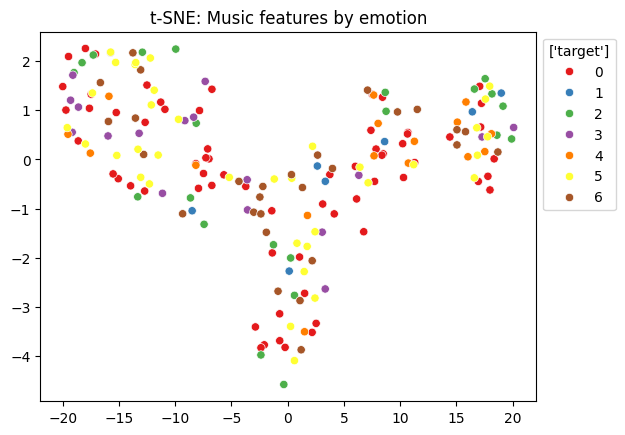

In [19]:
results = tsne_model.fit_transform(features)
print(results.shape)
palette = sns.color_palette('Set1', len(set(targets)))
graph = sns.scatterplot(x = results[:,0], y = results[:,1], hue = targets, palette = palette)
plt.title('t-SNE: Music features by emotion')
plt.legend(title = ['target'])
sns.move_legend(graph, 'upper left', bbox_to_anchor = (1,1))
plt.show()

In [197]:
# Normalize the featuers by each class
import numpy as np
def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x
es_sample = softmax(np.random.randn(1,7))# sample emotion score
es_sample 

array([[0.02705005, 0.0342272 , 0.05711862, 0.2294358 , 0.01302259,
        0.12739959, 0.51174615]])

(317, 2)


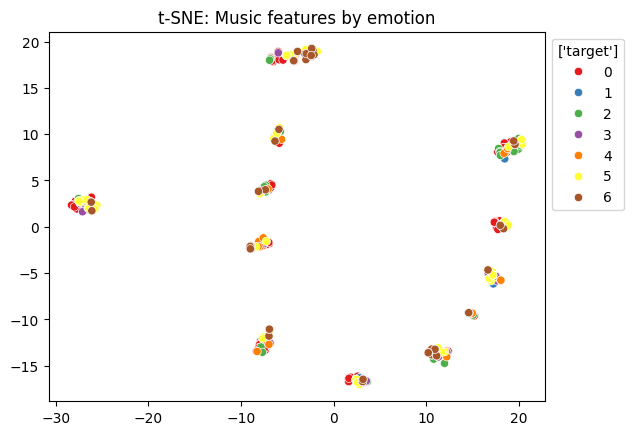

In [198]:
# T-sne plot for selected features
n_components = 2 # 2차원으로 차원 축소
tsne_model = TSNE(n_components = n_components)
results = tsne_model.fit_transform(selected_features)
print(results.shape)
palette = sns.color_palette('Set1', len(set(targets)))
graph = sns.scatterplot(x = results[:,0], y = results[:,1], hue = targets, palette = palette)
plt.title('t-SNE: Music features by emotion')
plt.legend(title = ['target'])
sns.move_legend(graph, 'upper left', bbox_to_anchor = (1,1))
plt.show()

(194, 2)


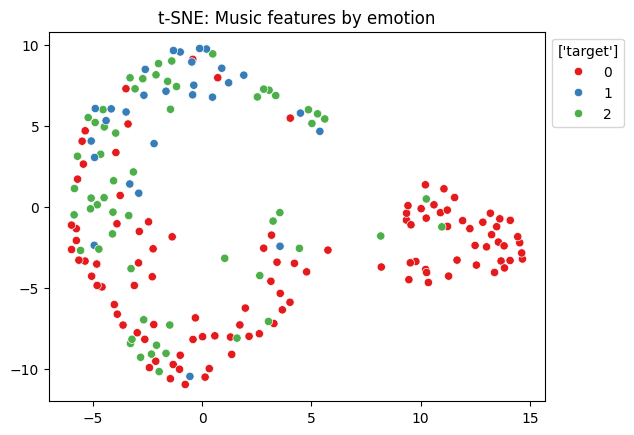

In [41]:
# selected variables: valence, acousticness
# sub_data.columns
selected_features = sub_data.loc[:, ['acousticness', 'valence']].to_numpy()
# selected_features = sub_data.loc[:, ['valence']].to_numpy()

# T-sne plot for selected features
n_components = 2 # 2차원으로 차원 축소
tsne_model = TSNE(n_components = n_components)
results = tsne_model.fit_transform(selected_features)
print(results.shape)
palette = sns.color_palette('Set1', len(set(targets)))
graph = sns.scatterplot(x = results[:,0], y = results[:,1], hue = targets, palette = palette)
plt.title('t-SNE: Music features by emotion')
plt.legend(title = ['target'])
sns.move_legend(graph, 'upper left', bbox_to_anchor = (1,1))
plt.show()